# Rainsmore Workshop - Day 3

# Pacakge install
Same to monday :
    
> ```conda activate rainsmore```

you can install the packages required by the project of this environment using the command

> ```conda install seaborn kneed` mlxtend```

if dont worck  install the older package :

> ``` install numpy scipy jupyter ipython matplotlib pandas scikit-learn keras tensorflow```

* seaborn - data visualization package
* kneed - identify the knee/elbow point of a line fit to the data
* mlxtend - tools and extensions for data science and Machine learning

## Dataset #1 description

This dataset comprises transmit and receive signal levels of radio links and rainfall measurements in locations close to the links' ones. It is of interest to analyze the correlation between radio signal levels and rainfall volumes in order to use the former ones to predict the latter ones. The avalaible dataset is provided as a comma separated value (csv) file with different fiels which short description is provided below.

### Dataset field description

0.   **times**: Time stamp of the measurement.
1.   **sens**: Link identifier (290 A-B or 523 A-B for the current data).
2.   **TSL_mean**: Mean Transmitted Signal Level (TSL) in dBm.
3.   **RSL_mean**: Mean Received Signal Level in dBm.
4.   **Rgage**: The measurement of the rainfall for the nearest rain gauge in mm.
5.   **freq**: Frequency of operation of the link in GHz.
6.   **length**: Radio link length (distance from A to B) in km.
7.   **cfakr**: estimated coeffient $a$ of the theoretical relationship between specifit attenuation $k$ (dB/km) and rain rate $R$ in mm/h, given by $k=aR^b$.
8.   **cfbkr**: estimated coeffient $b$ of the theoretical relationship between specifit attenuation $k$ (dB/km) and rain rate $R$ in mm/h, given by $k=aR^b$.
9.   **link**: Link description.
10.  **gage**: Rain gauge identifier (neareast rain gauge).
11.  **dist**: Distance between the middle of the radio link and the nearest rain gauge.
12.  **code**: Link code (290 or 523 for the current data)

# Prediction - it's rain or not?

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


data=pd.read_csv("Dataset_1_Link_AB_290_20210828_20210902.csv", sep=";")

# verify your number of observations and columns
# change separator if needed ',' or '\t' ...
print(data.shape[0], "observations (lines) by ", data.shape[1], "features (columns)")

576 observations (lines) by  14 features (columns)


## Data exploration

In [9]:
# quick view
print(data.head(n=1))
print('...')
print(data.tail(n=1))

                 times     sens  TSL_mean  RSL_mean  Rgage  freq  length  \
0  2021-08-28 00:10:00  290 A-B       5.0     -52.7    0.0  14.5    1.02   

    cfakr   cfbkr                                           link       gage  \
0  0.0473  1.1022  10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1  Meteo_IUT   

       dist  code company  
0  0.193579   290  Orange  
...
                   times     sens  TSL_mean  RSL_mean  Rgage  freq  length  \
575  2021-09-02 23:55:00  290 A-B       5.0     -53.4    0.8  14.5    1.02   

      cfakr   cfbkr                                           link       gage  \
575  0.0473  1.1022  10G_MPR_NDOGBONG_3 - MPR_MISSOKE_UNIVERSITE_1  Meteo_IUT   

         dist  code company  
575  0.193579   290  Orange  


In [10]:
# detection of Meta-Data 
# a Meta-data could be a unique value, or reduced number (Quality code)
# Put 
metaValue=1
card=[]
for i in range(data.shape[1]):
    card.append(len(data.iloc[:,i].unique()))
print(card)
[576, 1, 33, 23, 43, 1, 1, 1, 1, 1, 1, 1, 1, 1]
# extraction of non Meta information
subset= np.array(card)>metaValue
df=data.loc[:,subset]
print(df.head(n=3))
print("...")
print(df.tail(n=2))
           

[576, 1, 33, 23, 43, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                 times  TSL_mean  RSL_mean  Rgage
0  2021-08-28 00:10:00       5.0     -52.7    0.0
1  2021-08-28 00:25:00       5.0     -52.7    0.0
2  2021-08-28 00:40:00       5.0     -52.7    0.0
...
                   times  TSL_mean  RSL_mean  Rgage
574  2021-09-02 23:40:00       5.0     -53.4    0.0
575  2021-09-02 23:55:00       5.0     -53.4    0.8


Les signaux TSL et RSL permettent de récupérer des informations sur l'attenuation de lignes électriques/wifi/... généré en dBm (décibels par milliwatt).

De ces signaux, on essayera dans un premier temps de comprendre la dynamique des épisodes de pluie notamment de bien identifier leur début et fin de ces épisodes (signal Rgage Rain gauge, mesuré en mm per time).

1- Visualiser chaque signal en fonction du temps

2- Vérifier les corrélations éventuelles de manière statistique mais aussi par visualisation, existent-ils une relation simple indépendantes du temps ?

3- Existent-ils des événements particuliers. Essayez le kmeans sans prise en compte du temps ?

4- Est-il possible de prédire la pluie à H+1, H+12 la pluie et J+1, J+7. Proposer un modèle parmi ceux vu en cours.

## Data Exploration

In [11]:
# date identification
df['times']=pd.to_datetime(df.loc[:,"times"], format="%Y-%m-%d %H:%M:%S")
df.set_index("times", inplace=True)

/tmp/ipykernel_657/3840090137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['times']=pd.to_datetime(df.loc[:,"times"], format="%Y-%m-%d %H:%M:%S")


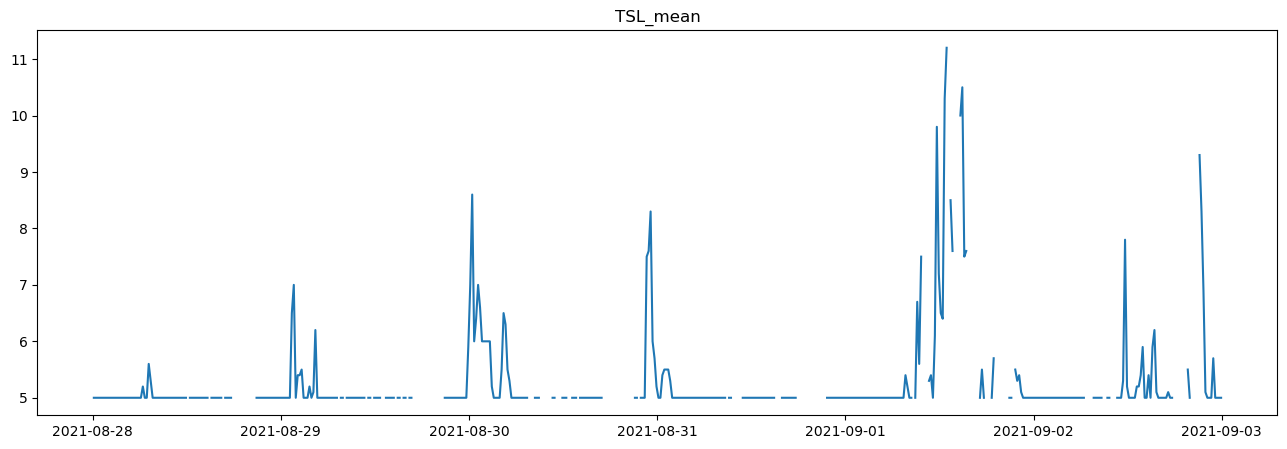

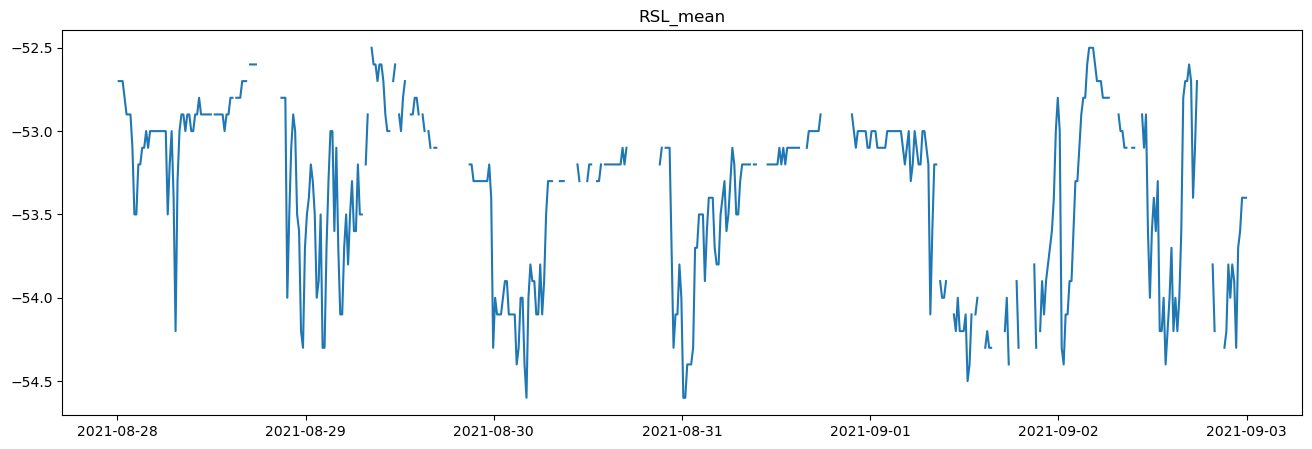

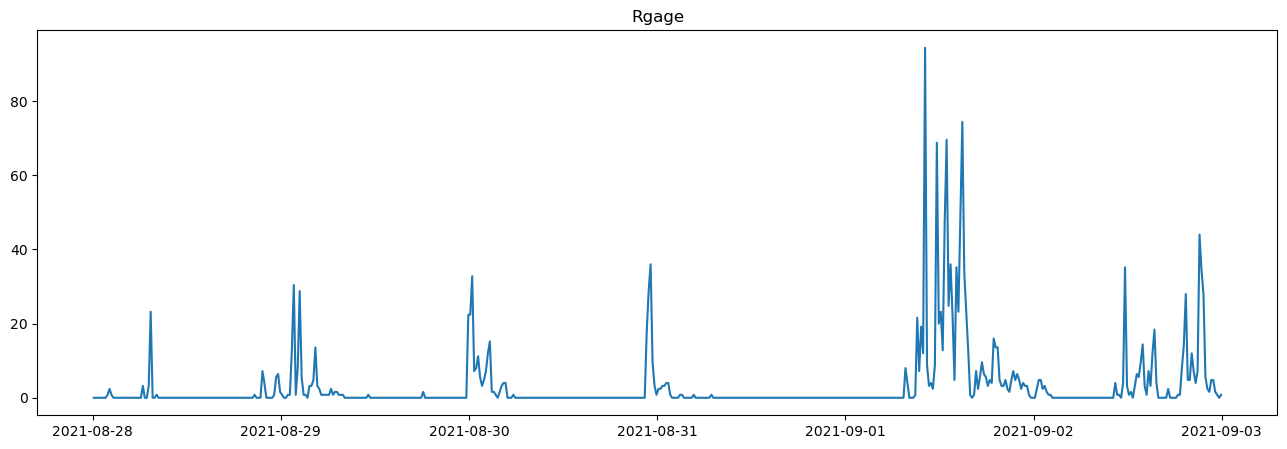

In [12]:
for n in df.columns:
    plt.figure(figsize= (16,5))
    plt.plot(df[n])
    plt.title(n)
    plt.show()

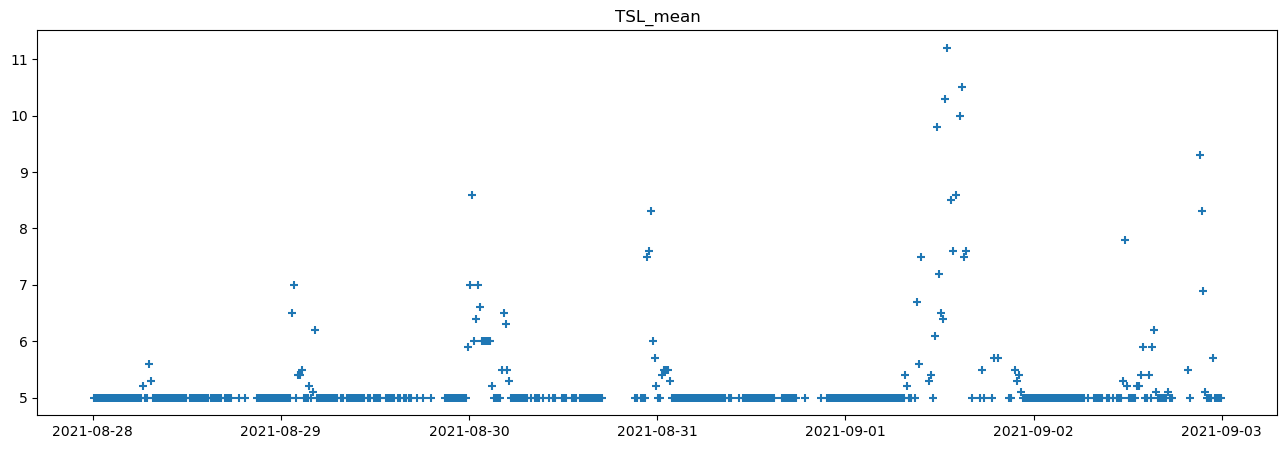

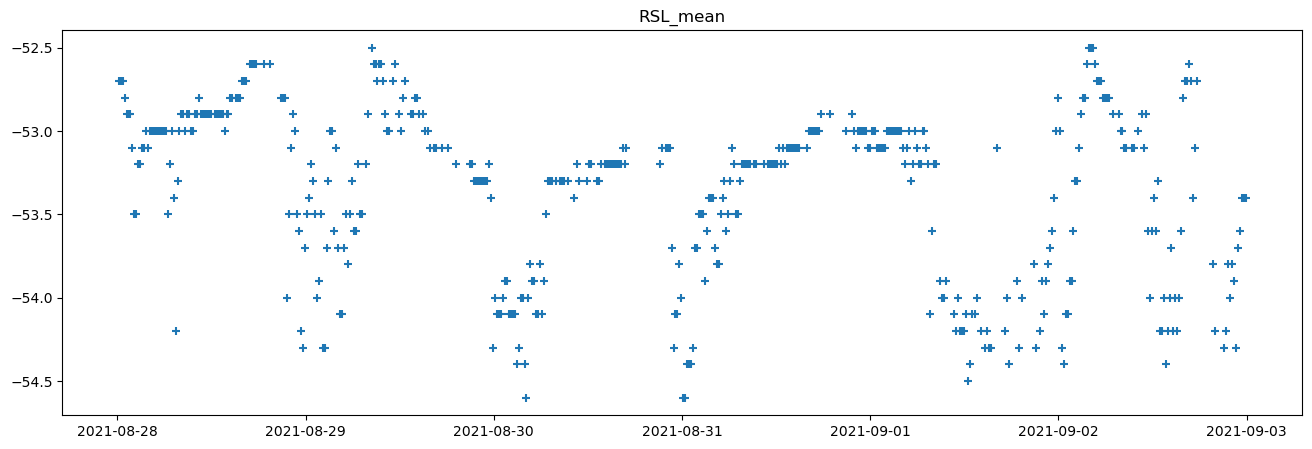

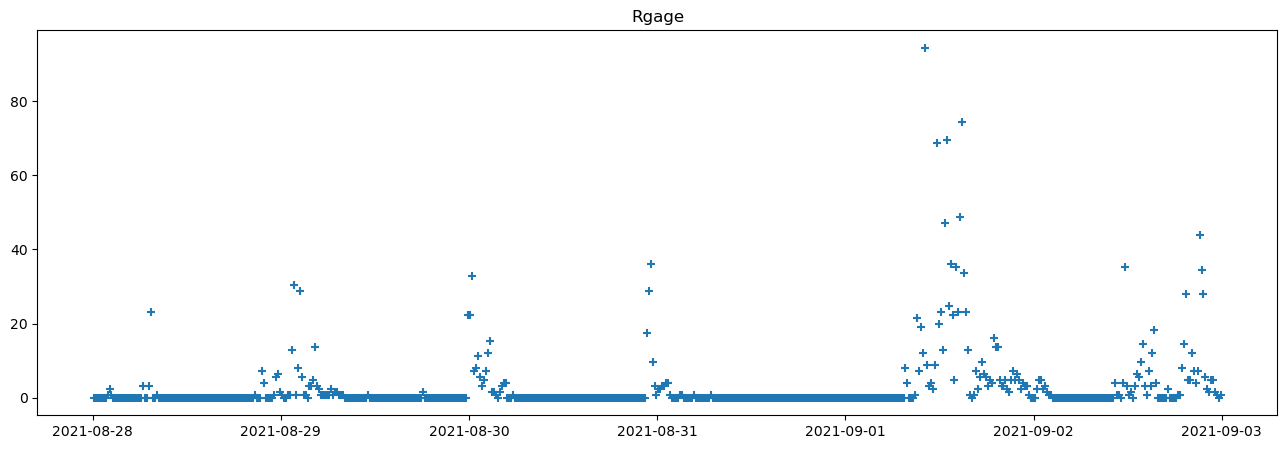

In [13]:
for n in df.columns:
    plt.figure(figsize= (16,5))
    plt.scatter(df.index,df[n],marker='+')
    plt.title(n)
    plt.show()

In [14]:
# correlation information
df.corr().round(2)

,TSL_mean,RSL_mean,Rgage
TSL_mean,1.00,-0.48,0.95
RSL_mean,-0.48,1.00,-0.53
Rgage,0.95,-0.53,1.00


## Identification of Pattern by unsupervised approach

In [15]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

df.describe()

,TSL_mean,RSL_mean,Rgage
count,451.000000,451.000000,576.000000
mean,5.260089,-53.355211,3.122222
std,0.814482,0.505954,9.213347
min,5.000000,-54.600000,0.000000
25%,5.000000,-53.750000,0.000000
50%,5.000000,-53.200000,0.000000
75%,5.000000,-53.000000,1.600000
max,11.200000,-52.500000,94.400000


In [16]:
#remove observations with NA information 
df.dropna(inplace=True)
df.describe()


/tmp/ipykernel_657/369810968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


,TSL_mean,RSL_mean,Rgage
count,451.000000,451.000000,451.000000
mean,5.260089,-53.355211,3.249667
std,0.814482,0.505954,9.118773
min,5.000000,-54.600000,0.000000
25%,5.000000,-53.750000,0.000000
50%,5.000000,-53.200000,0.000000
75%,5.000000,-53.000000,1.600000
max,11.200000,-52.500000,74.400000


In [17]:
# Normalisation

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

df_scaled.head()


,TSL_mean,RSL_mean,Rgage
0,-0.319685,1.296438,-0.356767
1,-0.319685,1.296438,-0.356767
2,-0.319685,1.296438,-0.356767
3,-0.319685,1.098573,-0.356767
4,-0.319685,0.900707,-0.356767


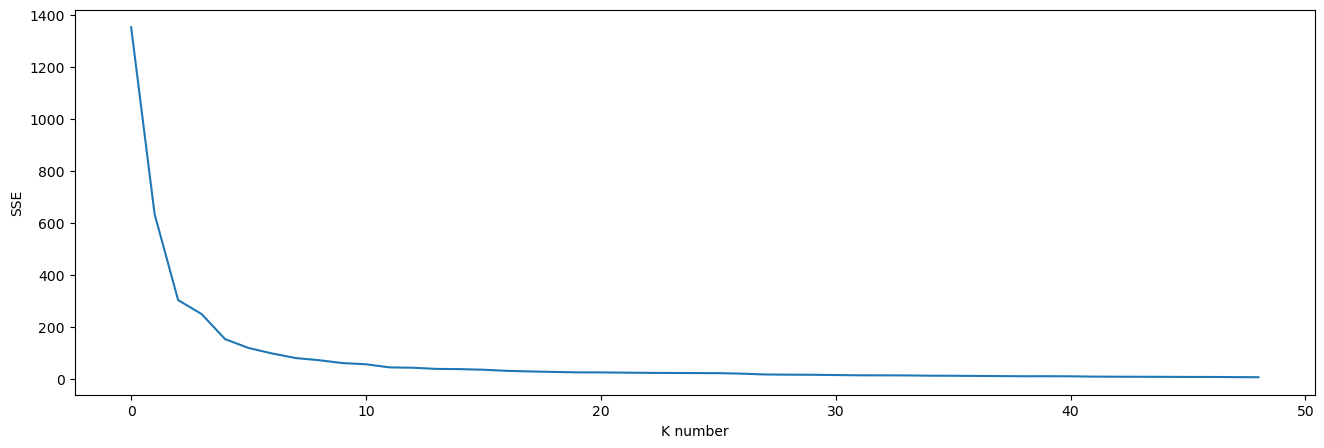

6

In [18]:
#identify pattern structure without temporal information
sse = []
Kmax = 50
for k in range(1, Kmax):
    kmeans = KMeans(init = "random", n_clusters = k, n_init = 10, max_iter=300, random_state = 42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)
plt.figure(figsize= (16,5))
plt.xlabel("K number")
plt.ylabel("SSE")
plt.plot(sse)    
plt.show()
kl = KneeLocator(range(1, Kmax), sse, curve="convex", direction="decreasing")
kl.elbow

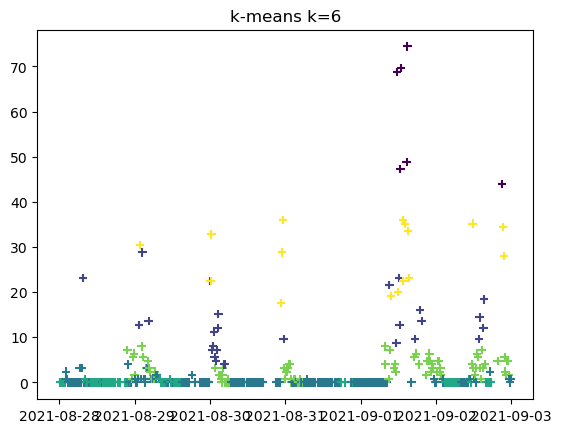

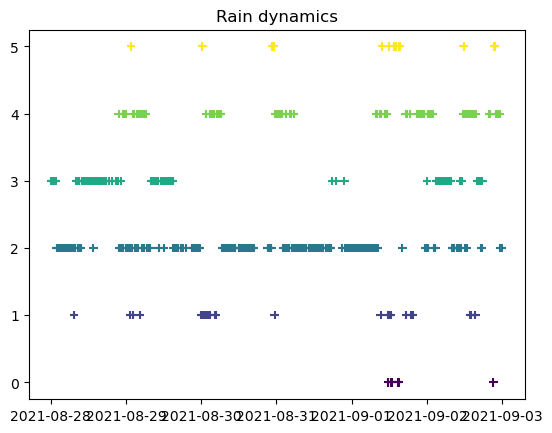

In [19]:
km1 = KMeans(init="random", n_clusters = kl.elbow, n_init=10, max_iter=100, random_state=42)
km1.fit(df_scaled)

plt.scatter(df.index,df['Rgage'], c=km1.labels_, marker='+')
plt.title(f"k-means k=6", fontdict={"fontsize": 12})
plt.show()

plt.scatter(df.index,km1.labels_, c=km1.labels_, marker='+')
plt.title("Rain dynamics")
plt.show()

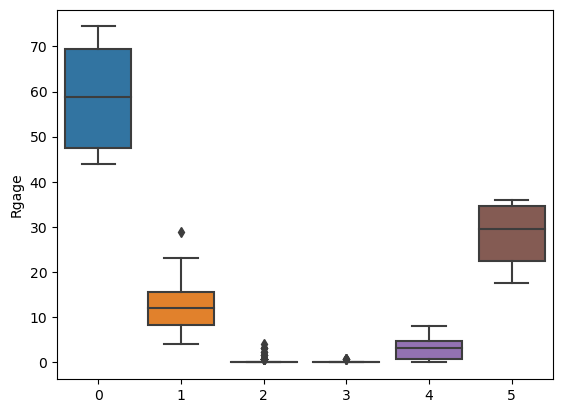

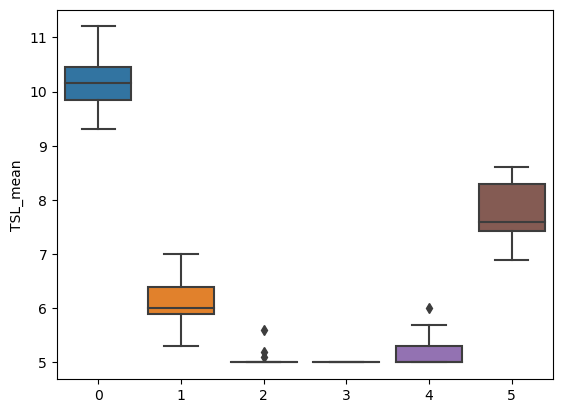

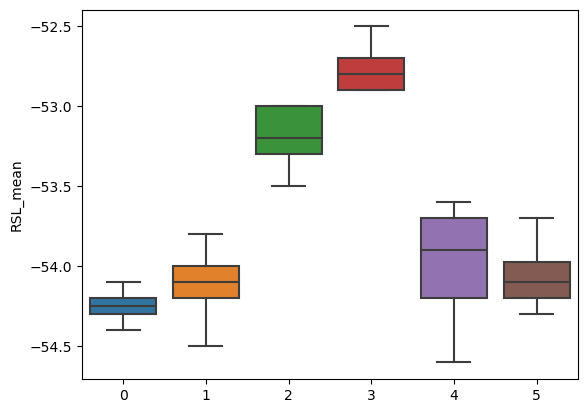

In [20]:
labels=km1.labels_
sns.boxplot(y=df.Rgage, x=labels) ; plt.show() 
sns.boxplot(y=df.TSL_mean, x=labels) ; plt.show() 
sns.boxplot(y=df.RSL_mean, x=labels) ; plt.show() 

In [21]:
proto=km1.cluster_centers_

## KNearest-Neighbors : clustering, regression, future prediction 

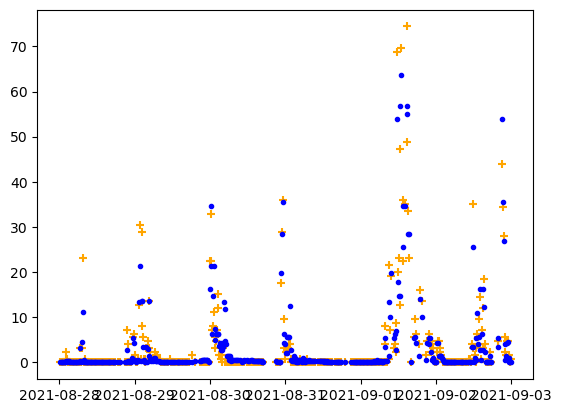

In [22]:
## Training as Regressor KNN

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Does it rain now according to TSL and RSL.

X=df.drop("Rgage",axis=1)
y=df.Rgage

knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X, y)

test_preds = knn_model.predict(X)
mse = mean_squared_error(y, test_preds)

mse

plt.scatter(df.index,y,c='orange',marker='+')
plt.scatter(df.index,test_preds,marker=".",c='blue')
plt.show()

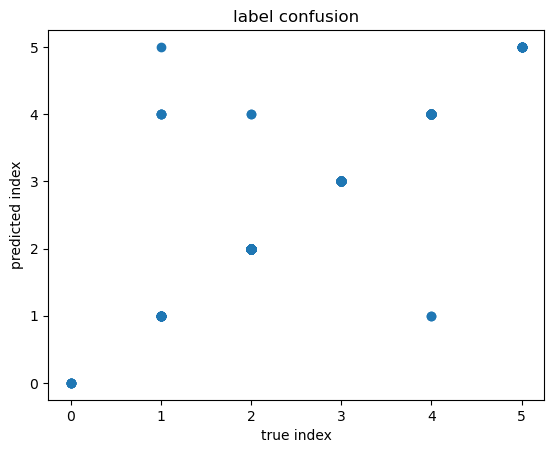

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

X=df.drop("Rgage",axis=1)
yl=labels

knn_classifier =KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X, yl)

test_preds = knn_classifier.predict(X)
mse = mean_squared_error(yl, test_preds)

mse

plt.scatter(yl,test_preds)
plt.title("label confusion")
plt.xlabel("true index")
plt.ylabel("predicted index")
plt.show()

#### Tomorrow, Rain or not ?

date min= 2021-08-28 00:10:00
date max= 2021-09-02 23:55:00


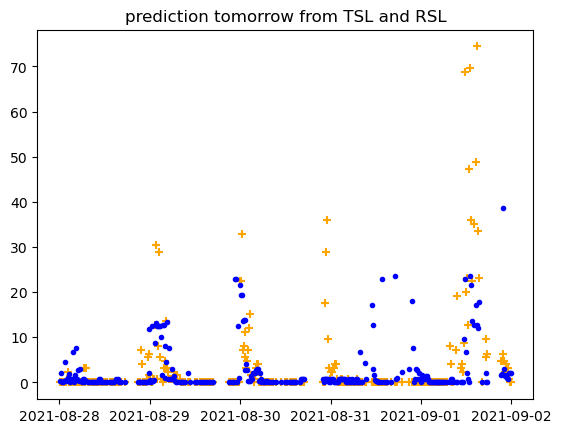

In [24]:
# Training for tomorrow
from datetime import timedelta

print("date min=",min(df.index))
print("date max=",max(df.index))
tomorrow = df.index + timedelta(minutes=60*24)
previous= tomorrow -timedelta(minutes=60*24)

#select current date with future date available
idf=[index for index, value in enumerate(tomorrow) if value in df.index]
idp=[index for index, value in enumerate(previous) if value in df.index]
exist=[x for x in idf if x in idp]

#print(len(exist))

df_future=df.iloc[exist]
df_now=df.loc[tomorrow[exist]]

X=df_now.drop("Rgage",axis=1)
y=df_future.Rgage

knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X, y)

test_preds = knn_model.predict(X)
mse = mean_squared_error(y, test_preds)

plt.scatter(df_future.index,y,c='orange',marker='+')
plt.scatter(df_future.index,test_preds,marker=".",c='blue')
plt.title("prediction tomorrow from TSL and RSL")
plt.show()

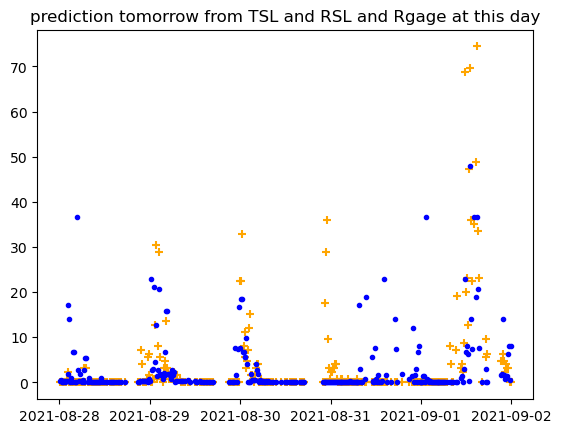

In [25]:
#Now Predict Tomorrow from TSL, RSL and Rgage
X=df_now
y=df_future.Rgage

knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X, y)

test_preds = knn_model.predict(X)
mse = mean_squared_error(y, test_preds)

plt.scatter(df_future.index,y,c='orange',marker='+')
plt.scatter(df_future.index,test_preds,marker=".",c='blue')
plt.title("prediction tomorrow from TSL and RSL and Rgage at this day")
plt.show()

### Linear Regression

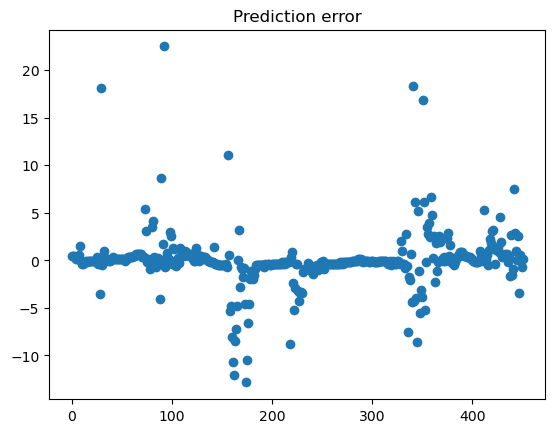

<generator object <genexpr> at 0x7eff31313140>
error range :-12.852812815218925; 22.507973360600733
error std: 2.8570768696911686
error mean:2.2198552432061666e-14


In [26]:
from sklearn.linear_model import LinearRegression

X=df.drop("Rgage",axis=1)
y=df.Rgage

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

ecart = np.array(y-y_pred)
ecartabsolu = np.array([abs(val) for val in ecart])
ecartcarre = np.array([val*val] for val in ecart)

plt.scatter(range(len(ecart)), ecart)
plt.title("Prediction error")
plt.show()

print(ecartcarre.min())

print(f"error range :{ecart.min()}; {ecart.max()}")
print(f"error std: {ecart.std()}")
print(f"error mean:{ecart.mean()}")

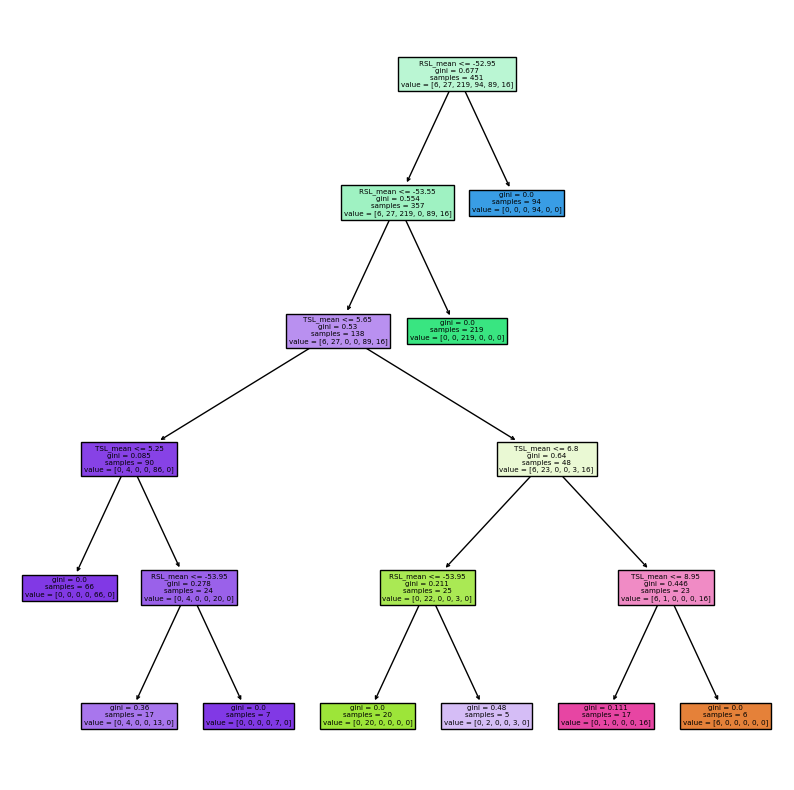

In [27]:
### Tree decision

# Tree definition - parameter tuning
from sklearn.tree import DecisionTreeClassifier 
arbreFirst = DecisionTreeClassifier(min_samples_split=20,min_samples_leaf=5)

#Tree learning
arbreFirst.fit(X, labels)
                                    
# tree view 
import matplotlib.pyplot as plt 
from sklearn import tree

plt.figure(figsize=(10,10)) 
tree.plot_tree(arbreFirst,feature_names = X.columns,filled=True) 
plt.show()

In [28]:
# rules' visualisation 
from sklearn.tree import export_text 
tree_rules = export_text(arbreFirst,feature_names = list(X.columns),show_weights=True)
print(tree_rules)

|--- RSL_mean <= -52.95
|   |--- RSL_mean <= -53.55
|   |   |--- TSL_mean <= 5.65
|   |   |   |--- TSL_mean <= 5.25
|   |   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 66.00, 0.00] class: 4
|   |   |   |--- TSL_mean >  5.25
|   |   |   |   |--- RSL_mean <= -53.95
|   |   |   |   |   |--- weights: [0.00, 4.00, 0.00, 0.00, 13.00, 0.00] class: 4
|   |   |   |   |--- RSL_mean >  -53.95
|   |   |   |   |   |--- weights: [0.00, 0.00, 0.00, 0.00, 7.00, 0.00] class: 4
|   |   |--- TSL_mean >  5.65
|   |   |   |--- TSL_mean <= 6.80
|   |   |   |   |--- RSL_mean <= -53.95
|   |   |   |   |   |--- weights: [0.00, 20.00, 0.00, 0.00, 0.00, 0.00] class: 1
|   |   |   |   |--- RSL_mean >  -53.95
|   |   |   |   |   |--- weights: [0.00, 2.00, 0.00, 0.00, 3.00, 0.00] class: 4
|   |   |   |--- TSL_mean >  6.80
|   |   |   |   |--- TSL_mean <= 8.95
|   |   |   |   |   |--- weights: [0.00, 1.00, 0.00, 0.00, 0.00, 16.00] class: 5
|   |   |   |   |--- TSL_mean >  8.95
|   |   |   |   |   |--- weights: [6

In [29]:
#impact of variables 
impVarFirst={"Variable":X.columns,"Importance":arbreFirst.feature_importances_} 
print(pd.DataFrame(impVarFirst).sort_values(by="Importance",ascending=False)) 


   Variable  Importance
1  RSL_mean    0.798622
0  TSL_mean    0.201378


In [30]:
predFirst_app = arbreFirst.predict(X) 
 
#distribution des predictions 
print(np.unique(predFirst_app,return_counts=True))

#matrice de confusion
from sklearn import metrics 
print(metrics.confusion_matrix(labels,predFirst_app))

#taux de reconnaissance –
print(f'pourcentage reco: {100*metrics.accuracy_score(labels,predFirst_app)}')

#taux d'erreur – 
print(f'taux erreur ={1.0 - metrics.accuracy_score(labels,predFirst_app)}')

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([  6,  20, 219,  94,  95,  17]))
[[  6   0   0   0   0   0]
 [  0  20   0   0   6   1]
 [  0   0 219   0   0   0]
 [  0   0   0  94   0   0]
 [  0   0   0   0  89   0]
 [  0   0   0   0   0  16]]
pourcentage reco: 98.4478935698448
taux erreur =0.01552106430155209


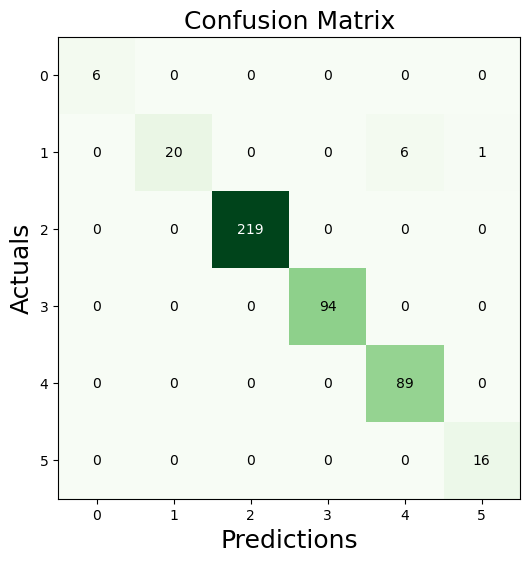

In [32]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix= metrics.confusion_matrix(labels,predFirst_app)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

**RandomForest as regressor**

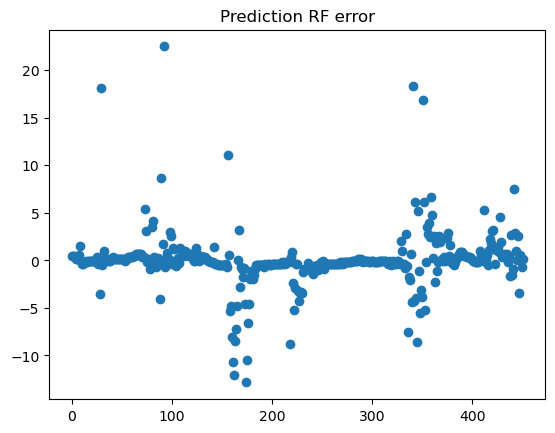

<generator object <genexpr> at 0x7eff314cc2e0>
error range :-12.852812815218925; 22.507973360600733
error std: 2.8570768696911686
error mean:2.2198552432061666e-14


In [33]:
## Random Forest

from sklearn.ensemble import RandomForestRegressor

X=df.drop("Rgage",axis=1)
y=df.Rgage

#build model
regRF =RandomForestRegressor(max_depth=2, random_state=0)
#learn model according dataset
regRF.fit(X, y)

#prediction - verify that Learning is sufficient
y_pred=regRF.predict(X)

y_pred = model.predict(X)

ecart = np.array(y-y_pred)
ecartabsolu = np.array([abs(val) for val in ecart])
ecartcarre = np.array([val*val] for val in ecart)

plt.scatter(range(len(ecart)), ecart)
plt.title("Prediction RF error")
plt.show()

print(ecartcarre.min())

print(f"error range :{ecart.min()}; {ecart.max()}")
print(f"error std: {ecart.std()}")
print(f"error mean:{ecart.mean()}")


## SVM

In [34]:
## SVM
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5,max_iter=300))
clf.fit(X, labels)

y_pred=clf.predict(X)
print(f'Linear SVM pourcentage reco: {100*metrics.accuracy_score(labels,y_pred)}')


from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, labels)

y_pred=clf.predict(X)
print(f'SVC pourcentage reco: {100*metrics.accuracy_score(labels,y_pred)}')


Linear SVM pourcentage reco: 90.68736141906874
SVC pourcentage reco: 96.45232815964523


/home/jovyan/.conda/envs/rainsmore2/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
